# In the following exercise we will use the built-in dataset loader for 20 newsgroups from scikit-learn. The dataset is called “Twenty Newsgroups”.  



In [1]:
from sklearn.datasets import fetch_20newsgroups

/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
categories = ['alt.atheism', 'soc.religion.christian','comp.graphics', 'sci.med']

In [3]:
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

In [4]:
#twenty_train.target_names[twenty_train.target[0], twenty_train.target[1], twenty_train.target[2], twenty_train.target[3]]
twenty_train.target_names[twenty_train.target[6]]

'soc.religion.christian'

In [5]:
len(twenty_train.data)

2257

In [6]:
len(twenty_train.filenames)

2257

In [7]:
print("\n".join(twenty_train.data[0].split("\n")[:3]))

From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton


In [8]:
print(twenty_train.target_names[twenty_train.target[0]])

comp.graphics


In [9]:
twenty_train.target[:10]

array([1, 1, 3, 3, 3, 3, 3, 2, 2, 2])

In [10]:
for t in twenty_train.target[:10]:
    print(twenty_train.target_names[t])

comp.graphics
comp.graphics
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
soc.religion.christian
sci.med
sci.med
sci.med


# Extracting features from text files

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

(2257, 35788)

In [12]:
count_vect.vocabulary_.get(u'algorithm')

4690

# We don't just want to count
* We will use tfidf as well
* TF-IDF is known as Term Frequency Inverse Document Frequency
* This normalizes the length of the document, then it targets the words thatt are unique to certian documents and assigns weights.

For example words that appear a lot like "the" are weighted much less than words like "abenomics".  we can create vector representations of sentences.  Simply put we can transform documents into numbers and lists of documents into dataframes.


In [13]:
from sklearn.feature_extraction.text import TfidfTransformer


In [14]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(2257, 35788)

In [15]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2257, 35788)

## Now that we have our features, we can train a classifier to try to predict the category of a post.

In [16]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

In [17]:
docs_new = ['God is love', 'OpenGL on the GPU is fast']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, twenty_train.target_names[category]))

'God is love' => soc.religion.christian
'OpenGL on the GPU is fast' => comp.graphics


## Building a pipeline
In order to make the vectorizer => transformer => classifier easier to work with, scikit-learn provides a Pipeline class that behaves like a compound classifier

In [18]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),])

* The names vect, tfidf, and clf are arbitrary.  You will see thier use in the section below.  We can now train the model with a single command

text_clf.fit(twenty_train.data, twenty_train.target)
Pipeline(...)

## Evaluation of the performance on the test set

In [22]:
import numpy as np
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)
docs_test = twenty_test.data
predicted = text_clf.predict(docs_test)
np.mean(predicted == twenty_test.target)

0.8348868175765646

* Looking at this we've achieved an accuracy of 83.4%.
* Now let's try doing better with a linear support vector machine (SVM)
* SVM's are regarded as one of the best text classification algorithms

*We can change the learner by just plugging a different classifier object into our pipeline*

In [24]:
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, random_state=42,
                                            max_iter=5, tol=None)),
                     ])
    

/home/nbuser/anaconda3_501/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [26]:
text_clf.fit(twenty_train.data, twenty_train.target)  
predicted = text_clf.predict(docs_test)
np.mean(predicted == twenty_test.target)  

0.9127829560585885

In [27]:
#91.2% is pretty good!
#let's get more detailed metrics for the performance results
from sklearn import metrics
print(metrics.classification_report(twenty_test.target, predicted, target_names=twenty_test.target_names))

                        precision    recall  f1-score   support

           alt.atheism       0.95      0.81      0.87       319
         comp.graphics       0.88      0.97      0.92       389
               sci.med       0.94      0.90      0.92       396
soc.religion.christian       0.90      0.95      0.93       398

           avg / total       0.92      0.91      0.91      1502



In [28]:
metrics.confusion_matrix(twenty_test.target, predicted)

array([[258,  11,  15,  35],
       [  4, 379,   3,   3],
       [  5,  33, 355,   3],
       [  5,  10,   4, 379]])

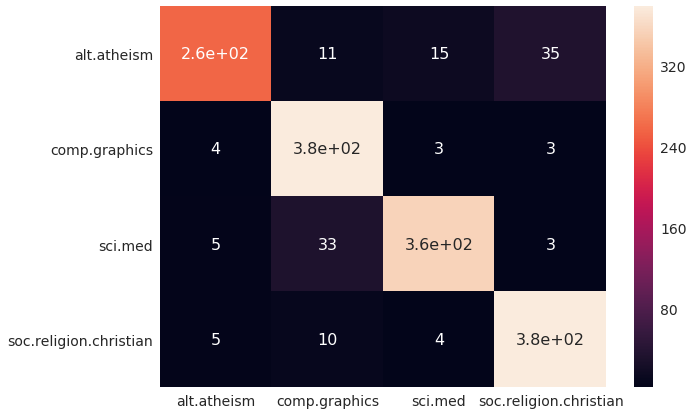

In [35]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = metrics.confusion_matrix(twenty_test.target, predicted)
names = ('alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian')
      
#df_cm = pd.DataFrame(array, range(4), range(4))
df_cm = pd.DataFrame(array, names, names)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size